Metric,Value
Market Cap (Billion USD),5.4
Current Price (USD),35.94
Industry,Capital Markets
Sector,Financial Services
Total Cash (Billion USD),10.93
Total Debt (Billion USD),5.43
Metric,Value
P/E Ratio,17.880
Profit Margin (%),9.840
Return on Assets (%),2.280


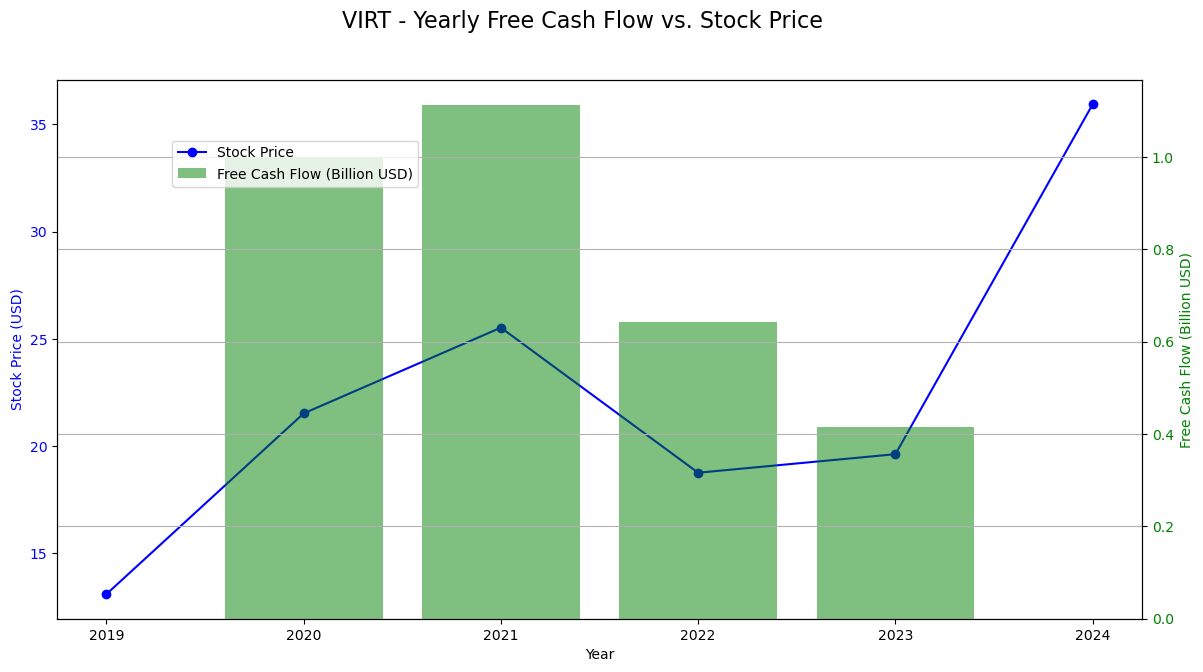

In [12]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def generate_stock_data(ticker):
    # Fetch stock data for the given ticker
    stock = yf.Ticker(ticker)
    
    # Get general information data
    general_info_data = {
        "Metric": [
            "Market Cap (Billion USD)", "Current Price (USD)", "Industry", "Sector",
            "Total Cash (Billion USD)", "Total Debt (Billion USD)"
        ],
        "Value": [
            round(stock.info.get('marketCap', 0) / 10**9, 2) if stock.info.get('marketCap') else "N/A",
            stock.info.get('currentPrice', "N/A"),
            stock.info.get('industry', "N/A"),
            stock.info.get('sector', "N/A"),
            round(stock.info.get('totalCash', 0) / 10**9, 2) if stock.info.get('totalCash') else "N/A",
            round(stock.info.get('totalDebt', 0) / 10**9, 2) if stock.info.get('totalDebt') else "N/A"
        ]
    }
    
    # Get ratios data including the new cash-to-market cap ratio
    cash_to_market_cap = (stock.info.get('totalCash', 0) / stock.info.get('marketCap')) if stock.info.get('marketCap') else "N/A"
    ratios_data = {
        "Metric": [
            "P/E Ratio", "Profit Margin (%)", "Return on Assets (%)", "Return on Equity (%)",
            "Debt-to-Equity Ratio (%)", "Quick Ratio", "Payout Ratio (%)", "Beta", "Cash-to-Market Cap Ratio (%)"
        ],
        "Value": [
            round(stock.info.get('trailingPE'), 2) if stock.info.get('trailingPE') else "N/A",
            round(100 * stock.info.get('profitMargins', 0), 2) if stock.info.get('profitMargins') else "N/A",
            round(100 * stock.info.get('returnOnAssets', 0), 2) if stock.info.get('returnOnAssets') else "N/A",
            round(100 * stock.info.get('returnOnEquity', 0), 2) if stock.info.get('returnOnEquity') else "N/A",
            round(stock.info.get('debtToEquity', 0), 2) if stock.info.get('debtToEquity') else "N/A",
            round(stock.info.get('quickRatio', 0), 2) if stock.info.get('quickRatio') else "N/A",
            round(100 * stock.info.get('payoutRatio', 0), 2) if stock.info.get('payoutRatio') else "N/A",
            stock.info.get('beta', "N/A"),
            round(cash_to_market_cap * 100, 2) if cash_to_market_cap != "N/A" else "N/A"
        ]
    }

    # Calculate stock returns for various periods
    historical_data = stock.history(period="5y")
    current_price = historical_data['Close'][-1]
    
    def calculate_return(start_price, end_price):
        if start_price and end_price:
            return float(round(((end_price - start_price) / start_price) * 100, 2))
        return "N/A"
    
    returns_data = {
        "Period": ["6 Months", "1 Year", "2 Years", "5 Years"],
        "Return (%)": [
            calculate_return(historical_data['Close'][-126], current_price),  # 6 months (~126 trading days)
            calculate_return(historical_data['Close'][-252], current_price),  # 1 year (~252 trading days)
            calculate_return(historical_data['Close'][-504], current_price),  # 2 years (~504 trading days)
            calculate_return(historical_data['Close'][0], current_price)       # 5 years
        ]
    }

    # Create DataFrames for the tables
    general_info_df = pd.DataFrame(general_info_data)
    ratios_df = pd.DataFrame(ratios_data)
    returns_df = pd.DataFrame(returns_data)

    # Apply color formatting for positive/negative returns
    def color_returns(val):
        color = 'green' if isinstance(val, (int, float)) and val > 0 else 'red'
        return f'color: {color}'

    # Render the HTML content with CSS
    html_content = f"""
    <style>
        .table-container {{
            display: flex;
            justify-content: space-around;
        }}
        .table {{
            display: inline-block;
            margin: 10px;
            padding: 10px;
            border: 1px solid #ddd;
            box-shadow: 2px 2px 10px #aaa;
        }}
        .table th, .table td {{
            padding: 8px 12px;
            text-align: left;
        }}
        .positive {{ color: green; }}
        .negative {{ color: red; }}
    </style>
    <div class="table-container">
        <div class="table">
            <h3>General Information for {ticker}</h3>
            {general_info_df.to_html(index=False, justify='left', border=0)}
        </div>
        <div class="table">
            <h3>Ratios for {ticker}</h3>
            {ratios_df.to_html(index=False, justify='left', border=0)}
        </div>
        <div class="table">
            <h3>Stock Returns for {ticker}</h3>
            {returns_df.style.applymap(color_returns, subset=['Return (%)']).to_html(index=False, justify='left', border=0)}
        </div>
    </div>
    """
    
    # Display the HTML with aligned tables
    display(HTML(html_content))
    
     # Fetch stock data for the given ticker
    stock = yf.Ticker(ticker)
    
    # Fetch historical stock price data
    historical_data = stock.history(period="5y")
    yearly_prices = historical_data['Close'].resample('Y').last()
    yearly_prices.index = yearly_prices.index.year  # Set index to year format for readability
    
    # Fetch yearly Free Cash Flow (FCF) data
    cashflow_data = stock.cashflow
    fcf_yearly = cashflow_data.loc['Free Cash Flow'] if 'Free Cash Flow' in cashflow_data.index else pd.Series()
    fcf_yearly = fcf_yearly[::-1]  # Reverse order to chronological
    fcf_yearly.index = fcf_yearly.index.year  # Set index to years

    # Plot the combo chart with stock price as a line and FCF as bars
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Plot stock price as a line chart
    ax1.plot(yearly_prices.index, yearly_prices, color='blue', marker='o', label='Stock Price')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Stock Price (USD)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Set up second y-axis for Free Cash Flow
    ax2 = ax1.twinx()
    ax2.bar(fcf_yearly.index, fcf_yearly / 10**9, color='green', alpha=0.5, label='Free Cash Flow (Billion USD)')
    ax2.set_ylabel('Free Cash Flow (Billion USD)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add legends and title
    fig.suptitle(f'{ticker} - Yearly Free Cash Flow vs. Stock Price', fontsize=16)
    fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9), bbox_transform=ax1.transAxes)
    plt.grid(True)
    plt.show()

# Example: Update the ticker
generate_stock_data('VIRT')  # Change the ticker here to refresh the data
